In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/otherdata/songs.csv
/kaggle/input/otherdata/members.csv
/kaggle/input/otherdata/song_extra_info.csv
/kaggle/input/stating/statlearning.py
/kaggle/input/trainset/train.csv
/kaggle/input/testset/test.csv


In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold

In [4]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LinearRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error
import xgboost as xgb
import lightgbm as lgb
import catboost
from catboost import Pool
from catboost import CatBoostClassifier

In [5]:
train = pd.read_csv('/kaggle/input/trainset/train.csv', dtype={'msno' : 'category','source_system_tab' : 'category','source_screen_name' : 'category','source_type' : 'category','target' : np.uint8,'song_id' : 'category'})
test = pd.read_csv('/kaggle/input/testset/test.csv', dtype={'msno' : 'category','source_system_tab' : 'category','source_screen_name' : 'category','source_type' : 'category','song_id' : 'category'})
songs = pd.read_csv('/kaggle/input/otherdata/songs.csv',dtype={'genre_ids': 'category','language' : 'category','artist_name' : 'category','composer' : 'category','lyricist' : 'category','song_id' : 'category'})
members = pd.read_csv('/kaggle/input/otherdata/members.csv',dtype={'city' : 'category','bd' : np.uint8,'gender' : 'category','registered_via' : 'category'},parse_dates=['registration_init_time','expiration_date'])
songs_extra_info = pd.read_csv('/kaggle/input/otherdata/song_extra_info.csv')

In [6]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [7]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [8]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [9]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [10]:
songs_extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


## Meta-data Pre-processing

In [11]:
train = train.merge(songs, on = 'song_id', how = 'left')
test = test.merge(songs, on = 'song_id', how = 'left')

In [12]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0


In [13]:
# Member data
members['reg_year'] = members['registration_init_time'].dt.year
members['reg_month'] = members['registration_init_time'].dt.month
members['reg_date'] = members['registration_init_time'].dt.day
members['duration'] = members['expiration_date'].subtract(members['registration_init_time']).dt.days.astype(int)
members['exp_year'] = members['expiration_date'].dt.year
members['exp_month'] = members['expiration_date'].dt.month
members['exp_date'] = members['expiration_date'].dt.day
members.drop(["registration_init_time", "expiration_date"], axis = 1, inplace = True)
members.head()

,msno,city,bd,gender,registered_via,reg_year,reg_month,reg_date,duration,exp_year,exp_month,exp_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011,8,20,2223,2017,9,20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015,6,28,725,2017,6,22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016,4,11,457,2017,7,12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015,9,6,1,2015,9,7
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017,1,26,138,2017,6,13


In [14]:
train = train.merge(members, on = 'msno', how = 'left')
test = test.merge(members, on = 'msno', how = 'left')

In [15]:
# songs_extra_info
def isrc_cc(x):
    if type(x) == str:
        country_code = x[:2]
        return country_code
    else:
        return np.nan

def isrc_rc(x):
    if type(x) == str:
        registrant_code = x[2:5]
        return registrant_code
    else:
        return np.nan
    
def isrc_ry(x):
    if type(x) == str:
        reference_year = int(x[5:7])
        return reference_year
    else:
        return np.nan

def isrc_dc(x):
    if type(x) == str:
        d_code = x[7:]
        return d_code
    else:
        return np.nan

songs_extra_info["cc"] = songs_extra_info["isrc"].apply(isrc_cc)
songs_extra_info["rc"] = songs_extra_info["isrc"].apply(isrc_rc)
songs_extra_info["ry"] = songs_extra_info["isrc"].apply(isrc_ry)
songs_extra_info["dc"] = songs_extra_info["isrc"].apply(isrc_dc)

In [16]:
songs_extra_info.drop("isrc", axis = 1, inplace = True)
train = train.merge(songs_extra_info, on = 'song_id', how = 'left')
test = test.merge(songs_extra_info, on = 'song_id', how = 'left')
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,reg_date,duration,exp_year,exp_month,exp_date,name,cc,rc,ry,dc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,2,2103,2017,10,5,Good Grief,GB,UM7,16.0,02854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,...,25,2301,2017,9,11,Lords of Cardboard,US,3C6,99.0,10183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,25,2301,2017,9,11,Hip Hop Is Dead(Album Version (Edited)),US,UM7,6.0,18761
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,25,2301,2017,9,11,Disco Africa,GB,UQH,10.0,00063
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,2,2103,2017,10,5,Sleep Without You,QM,3E2,16.0,06003


## Dealing with Missing Values

In [17]:
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_train = pd.DataFrame({'Missing Ratio' :round(train_na,4)})
missing_train

,Missing Ratio
lyricist,43.0882
gender,40.1425
composer,22.7140
dc,7.8328
ry,7.8328
rc,7.8328
cc,7.8328
source_screen_name,5.6226
genre_ids,1.6056
source_system_tab,0.3368


In [18]:
# Deal with Missing value
train["lyricist"] = train["lyricist"].cat.add_categories(['lyricist_not_available'])
train["lyricist"].fillna("lyricist_not_available", inplace = True)
test["lyricist"] = test["lyricist"].cat.add_categories(['lyricist_not_available'])
test["lyricist"].fillna("lyricist_not_available", inplace = True)
train["gender"] = train["gender"].cat.add_categories(['gender_not_available'])
train["gender"].fillna("gender_not_available", inplace = True)
test["gender"] = test["gender"].cat.add_categories(['gender_not_available'])
test["gender"].fillna("gender_not_available", inplace = True)
train["composer"] = train["composer"].cat.add_categories(['composer_not_available'])
train["composer"].fillna("composer_not_available", inplace = True)
test["composer"] = test["composer"].cat.add_categories(['composer_not_available'])
test["composer"].fillna("composer_not_available", inplace = True)
train["dc"].fillna("00001", inplace = True)
test["dc"].fillna("00001", inplace = True)
train["ry"].fillna(train["ry"].median(), inplace = True)
test["ry"].fillna(test["ry"].median(), inplace = True)
train["rc"].fillna("UM7", inplace = True)
test["rc"].fillna("UM7", inplace = True)
train["cc"].fillna("TW", inplace = True)
test["cc"].fillna("TW", inplace = True)
train["source_screen_name"].fillna("Local playlist more" ,inplace = True)
test["source_screen_name"].fillna("Local playlist more", inplace = True)
train["genre_ids"].fillna("465", inplace = True)
test["genre_ids"].fillna("465", inplace = True)
train["source_system_tab"].fillna("my library", inplace = True)
test["source_system_tab"].fillna("my library", inplace = True)
train["source_type"].fillna("local-library", inplace = True)
test["source_type"].fillna("local-library", inplace = True)
train["name"].fillna("name_not_available", inplace = True)
test["name"].fillna("name_not_available", inplace = True)
train["language"].fillna("3.0", inplace = True)
test["language"].fillna("3.0", inplace = True)
train["artist_name"].fillna("Various Artists", inplace = True)
test["artist_name"].fillna("Various Artists", inplace = True)
train["song_length"].fillna(train["song_length"].median(), inplace = True)
test["song_length"].fillna(test["song_length"].median(), inplace = True)
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_train = pd.DataFrame({'Missing Ratio' :round(train_na,4)})
missing_train

,Missing Ratio


## Adding New Feature: “Standard_target_sum_by_Artist”

In [19]:
artist_popu = pd.DataFrame(train.groupby("artist_name")["target"].sum())
artist_popu.loc["Various Artists","target"] = artist_popu["target"].mean()
artist_popu = artist_popu.sort_values(by="target" , ascending=False)
artist_popu["target"] = artist_popu["target"]/artist_popu["target"].max()
artist_popu.reset_index(inplace = True)
artist_popu.rename({"target":"target_by_Artist"}, inplace = True, axis = 1)
artist_popu

,artist_name,target_by_Artist
0,周杰倫 (Jay Chou),1.000000
1,五月天 (Mayday),0.900202
2,林俊傑 (JJ Lin),0.602538
3,田馥甄 (Hebe),0.538917
4,玖壹壹,0.391742
...,...,...
222358,Gardenside,0.000000
222359,Gardi,0.000000
222360,Garina Project,0.000000
222361,Garlum Lau,0.000000


In [20]:
train = train.merge(artist_popu, on = 'artist_name', how = 'left')
test = test.merge(artist_popu, on = 'artist_name', how = 'left')

In [21]:
train.drop(["msno", "song_id"], axis = 1, inplace = True)
test.drop(["id","msno", "song_id"], axis = 1, inplace = True)
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')

In [22]:
index_train, index_vali = train_test_split(np.array(train.index), train_size = 0.8, random_state = 1)
train_set = train.loc[index_train,:].copy() 
validation_set = train.loc[index_vali,:].copy()
y_train = train_set["target"].copy()
x_train = train_set.drop("target", axis = 1)
y_valid = validation_set["target"].copy()
x_valid = validation_set.drop("target", axis = 1)

## Tuning Parameters

In [ ]:
param_test1 = {
 'n_estimators':[200， 400， 600， 800， 1000， 1200]
}
gsearch1 = GridSearchCV(estimator = lgb.LGBMClassifier( objective='binary', n_estimators = 500,num_leaves = 54, max_bin = 256, max_depth = 10, subsample  = 0.9, colsample_bytree = 0.9, metric = 'auc',
                              learning_rate = 0.2, reg_alpha = 0.1, reg_lambda = 1, random_state = 3, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test1, n_jobs=4,iid=False, cv=3)
gsearch1.fit(x_train, y_train)
gsearch1.cv_results_, gsearch1.best_params_,     gsearch1.best_score_

In [ ]:
param_test2 = {
 'max_depth':[6, 8,10],
 'num_leaves':[30, 40, 50, 60]
}
gsearch2 = GridSearchCV(estimator = lgb.LGBMClassifier(objective='binary', n_estimators = 800,num_leaves = 20, max_bin = 256, max_depth = 12, subsample  = 0.9, colsample_bytree = 0.9, metric = 'auc',
                              learning_rate = 0.2, reg_alpha = 0.1, reg_lambda = 1, random_state = 3, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, n_jobs = 4,iid = False, cv=3)
gsearch2.fit(x_train, y_train)
gsearch2.cv_results_, gsearch2.best_params_,     gsearch2.best_score_

In [ ]:
param_test4 = {
 'subsample':[0.7, 0.8, 0.9, 1],
 "colsample_bytree":[0.7, 0.8, 0.9,1]
}
gsearch4 = GridSearchCV(
    estimator = lgb.LGBMClassifier(objective='binary', n_estimators = 800,num_leaves = 54, max_bin = 256, max_depth = 10, subsample  = 0.9, colsample_bytree = 0.9, metric = 'auc',
                              learning_rate = 0.2, reg_alpha = 0.1, reg_lambda = 1, random_state = 3, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, n_jobs = 4,iid = False, cv=3)
gsearch4.fit(x_train, y_train)
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

In [ ]:
param_test5 = {
 'reg_alpha':[0.0001, 0.1, 1, 10, 100],
 "reg_lambda":[0.0001, 0.1, 1, 10, 100]
}
gsearch5 = GridSearchCV(
    estimator = lgb.LGBMClassifier(objective='binary', n_estimators = 800,num_leaves = 54, max_bin = 256, max_depth = 10, subsample  = 0.9, colsample_bytree = 0.9, metric = 'auc',
                              learning_rate = 0.2, reg_alpha = 0.1, reg_lambda = 1, random_state = 3, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, n_jobs = 4,iid = False, cv=3)
gsearch5.fit(x_train, y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

## Modelling: LightGBM

In [23]:
model_lgb = lgb.LGBMClassifier (objective='binary', n_estimators = 800,num_leaves = 54, max_bin = 256, max_depth = 10, subsample  = 0.9, colsample_bytree = 0.9, metric = 'auc',
                              learning_rate = 0.2, reg_alpha = 0.1, reg_lambda = 1, random_state = 3)
model_lgb.fit(x_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
               importance_type='split', learning_rate=0.2, max_bin=256,
               max_depth=10, metric='auc', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
               n_jobs=-1, num_leaves=54, objective='binary', random_state=3,
               reg_alpha=0.1, reg_lambda=1, silent=True, subsample=0.9,
               subsample_for_bin=200000, subsample_freq=0)

In [24]:
model_lgb.score(x_train, y_train), model_lgb.score(x_valid, y_valid)

(0.7037764231182524, 0.6726402997253782)

In [25]:
lgb_pred = model_lgb.predict(x_valid)

## Modelling Result

In [26]:
from sklearn.metrics import confusion_matrix
lgb_cm = confusion_matrix(y_valid, lgb_pred)
lgb_cm

array([[465770, 266349],
       [216665, 526700]])

In [31]:
lgb_cm[0][0]/(lgb_cm[0][0] + lgb_cm[1][0])

0.6825118875790368

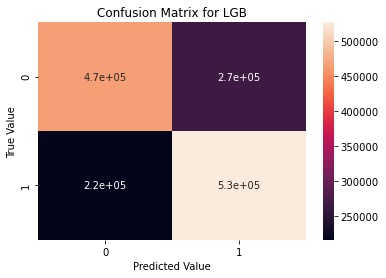

In [32]:
sns.heatmap(lgb_cm,annot=True)
plt.title("Confusion Matrix for LGB")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.show()

In [29]:
import sys
sys.path.append("/kaggle/input/stating")
import statlearning

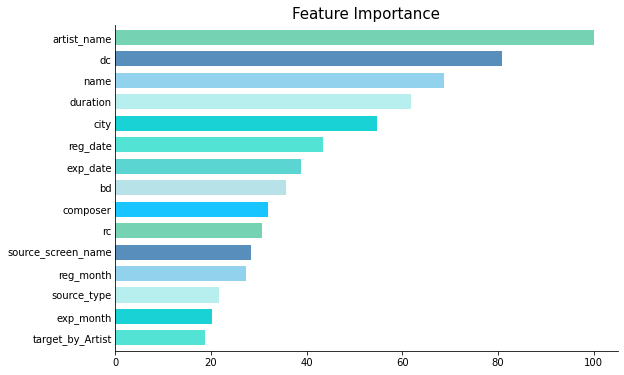

In [30]:
from statlearning import plot_feature_importance
plot_feature_importance(model_lgb,x_train.columns,15)
plt.show()

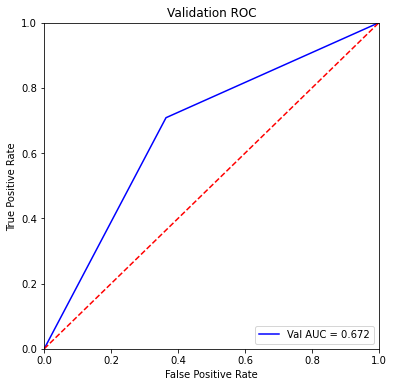

In [33]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_valid, lgb_pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

cats = x_train.columns[x_train.dtypes == "category"]
for col in cats:
    x_train[col] = train[col].astype('object')
    x_valid[col] = test[col].astype('object')
idx = list(range(26))
idx = [i for i in range(26) if list(x_train.dtypes == object)[i]]

catboost_model = CatBoostClassifier(
    iterations = 500,
    random_seed = 10,
    leaf_estimation_iterations = 1,
    od_type='Iter',
     od_wait = 25,
    verbose = 1000,
    depth = 6,
    eval_metric = "AUC",
    max_ctr_complexity = 3
)
catboost_model.fit(x_train, y_train, cat_features = idx)

catboost_model.score(x_train, y_train), catboost_model.score(x_valid, y_valid)